# Создание модуля для распознавания уровня модуляции QAM сигнала

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_pickle('/content/drive/MyDrive/Thesis/QAM_symbols_df.csv')

Класс QAMDA имеет 4 метода:
- Конструктор, который принимает параметры : `[bw_method, decimation, distance, window, prominence]`
- Метод `get_params`, которые возвращает словарь со значениями параметров
- Метод `return_closest`, для округления полученного алгоритмом значения до ближайшего из `[4, 16, 64, 256, 1024]`
- Метод `analyze`, который анализирует последовательности для определения уровня модуляции

In [3]:
    from scipy.signal import find_peaks
    from scipy.stats.kde import gaussian_kde

In [4]:
class QAMDA():
  ''' QAM Distribution Analyzer
  A class that allows you to analyze the distribution of 
  a QAM signal to recognize the modulation level
  '''
  # [bw_method, децимации, distance, prominence]
  def __init__(self,
               bw_method=0.05,
               decimation=24,
               distance=24,
               window=4,
               prominence=(0.08, 1.1)
               ):
    self.bw_method=bw_method
    self.decimation=int(decimation)
    self.distance=int(distance)
    self.window=int(window)
    self.prominence=prominence

  def get_parameters(self):
    return {'bw_method':self.bw_method,
            'decimation':self.decimation,
            'distance':self.distance,
            'window':self.window,
            'prominence':self.prominence}

  def return_closest(self, n):
    return min([4, 16, 64, 256, 1024], key=lambda x:abs(x-n))

  def analyze(self, consqs):
    answer = []
    for cons in consqs:
      all_QAM = np.concatenate((abs(cons.real), abs(cons.imag)))
      density = gaussian_kde(all_QAM, bw_method = self.bw_method)
      N = len(all_QAM)
      x = np.linspace(0, 1, int(N/self.decimation)) # создание массива иксов с децимацией в 16 раз
      # Создание массива со значениями функции яд. оценки
      derivation = np.array(density(x))
      # Нормировка значений функции ядерной оценки
      derivation = derivation/max(derivation)
      # Небольшое сглаживания фильтром скользящего среднего
      derivation = pd.Series(derivation).rolling(window=self.window).mean().values
      # минимальное расстояние между пиками
      distance =  int(len(x)*0.707/self.distance)
      # prominence - параметр видимости пика
      maxima = np.array(find_peaks(derivation, 
                                  distance=distance, 
                                  prominence=self.prominence))
      answer.append(self.return_closest((len(maxima[0])**2)*4))
    return answer


In [5]:
Analyzer = QAMDA()

In [6]:
Analyzer.get_parameters()

{'bw_method': 0.05,
 'decimation': 24,
 'distance': 24,
 'prominence': (0.08, 1.1),
 'window': 4}

In [7]:
result = Analyzer.analyze(np.array(df.QAM_symbols))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [12]:
df1 = df.iloc[:]

In [13]:
df1

,M,SNR,Phase_shift,QAM_symbols
1,4,50,0,"[(0.7014392993075365-0.6989112769319755j), (0...."
2,4,50,0,"[(-0.7067526946873619-0.6995223913305271j), (0..."
3,4,50,0,"[(-0.6996921958171798+0.7009840192354847j), (-..."
4,4,50,3,"[(-0.7398838731040926+0.664625874417456j), (0...."
5,4,50,3,"[(0.739909895597325-0.6611057921027184j), (0.6..."
...,...,...,...,...
12086,1024,0,87,"[(0.18522224139101126+0.15108979133587475j), (..."
12087,1024,0,87,"[(-0.22127741229059017+0.07121604374153466j), ..."
12088,1024,0,90,"[(-0.40020864490078795-0.18589912117816118j), ..."
12089,1024,0,90,"[(-0.3619966950003602+0.04947952938787332j), (..."


In [14]:
df1['Answer'] = result

In [15]:
df1['Result'] = (df1.Answer == df1.M)

Результаты точности метода для общего датасета по уровню модуляции

In [16]:
df1.drop(["QAM_symbols", 'Phase_shift', 'Answer', 'SNR'], axis=1)\
.groupby(by=['M'], as_index=False).mean()


,M,Result
0,4,0.239041
1,16,0.343672
2,64,0.262614
3,256,0.253102
4,1024,0.046733


Общая точность метода для общего датасета

In [17]:
df1.Result.mean()

0.22903225806451613

Точность метода по уровню модуляции, при условии отсуствия фазового сдвига

In [18]:
df2 = df1[df1.Phase_shift==0]
df2['Result'] = (df2.Answer == df2.M)
df2.drop(["QAM_symbols", 'Phase_shift', 'Answer', 'SNR'], axis=1)\
.groupby(by=['M'], as_index=False).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,M,Result
0,4,0.923077
1,16,0.923077
2,64,0.743590
3,256,0.564103
4,1024,0.423077


Общая точность метода, при условии отсуствия фазового сдвига

In [19]:
df2.Result.mean()

0.7153846153846154

In [22]:
df3 = df2.drop(["QAM_symbols", 'Phase_shift', 'Answer'], axis=1)
df3.SNR[(df.SNR >= 0) & (df.SNR < 15)] = '[0, 15)'
df3.SNR[(df.SNR >= 15) & (df.SNR < 30)] = '[15, 30)'
df3.SNR[(df.SNR >= 30) & (df.SNR <= 50)] = '[30, 50)'
df3.groupby(by=['M', 'SNR'], as_index=False).mean().transpose()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
M,4,4,4,16,16,16,64,64,64,256,256,256,1024,1024,1024
SNR,"[0, 15)","[15, 30)","[30, 50)","[0, 15)","[15, 30)","[30, 50)","[0, 15)","[15, 30)","[30, 50)","[0, 15)","[15, 30)","[30, 50)","[0, 15)","[15, 30)","[30, 50)"
Result,0.75,1,1,0.75,1,1,0.166667,1,1,0,0.52381,1,0,0,1


Text(0, 0.5, 'Точность')

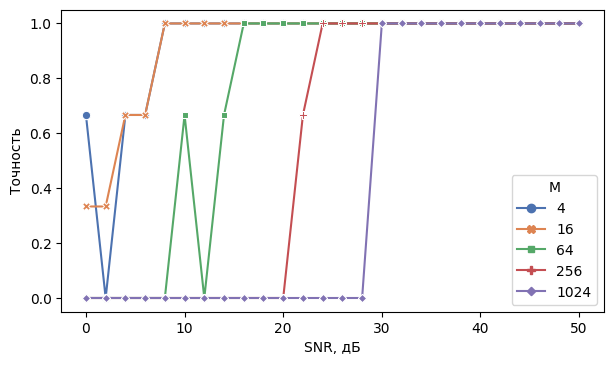

In [23]:
df4 = df2.drop(["QAM_symbols", 'Phase_shift', 'Answer'], axis=1)\
.groupby(by=['M', 'SNR'], as_index=False).mean()
plt.figure(figsize=(7,4), dpi=100)
sns.lineplot(x='SNR', y='Result', data=df4, hue='M',
             style='M', markers=True, dashes=False,
             palette='deep')
plt.xlabel('SNR, дБ')
plt.ylabel('Точность')

# Подбор оптимальных параметров
Так как наша модель имеет странные результаты для QAM4 где при меньших значения сигнал\шум получаются результаты лучше, чем при больших, следовательно параметры, которые были подобраны нуждаются в доработке.
Поэтому сделаем алгоритм, который переберёт параметры модели для того, чтобы определить наилучший результат 
Для подбора оптимальных параметров будем использовать выборку, в которой отсуствует фазовый сдвиг
Поиск оптимальных параметров будет осуществляться среди следующих значений
- bw_method `[0.01, 0.05, 0.08 , 0.1]`, 4 варианта
- decimation `[12, 24, 32]`, 3 варианта
- distance `[12, 24, 32]`, 3 варианта
- window `[4, 8, 12, 16, 20]`, 5 вариантов
- prominence `[0.03, 0.05, 0.08]`, 3 варианта

Таким образом у нас получается 540 вариантов моделей, среди которых следует определить наилучшую

In [ ]:
opt_par_df = pd.DataFrame({'bw_method':[],
            'decimation':[],
            'distance':[],
            'window':[],
            'prominence':[],
            'total':[],
            '4':[],
            '16':[],
            '64':[],
            '256':[],
            '1024':[]})

In [ ]:
opt_par_df

,bw_method,decimation,distance,window,prominence,total,4,16,64,256,1024


In [25]:
test_df = df[df.Phase_shift==0].drop('Phase_shift', axis=1)
QAM_test = test_df.QAM_symbols
test_df = test_df.drop('QAM_symbols', axis=1)

In [ ]:
from tqdm.notebook import tqdm # Установка прогресс бара
# Перебор параметров
for w in tqdm([4, 8, 12, 16, 20]):
  window = w
  for p in [0.03, 0.05, 0.08]:
    prominence = (p, 1.1) 
    for b in [0.01, 0.05, 0.08 , 0.1]:
      bw_method = b
      for de in [12, 24, 32]:
        decimation = de
        for di in [12, 24, 32]:
          distance = di
          # Создание модуля с текущими параметрами
          Analyzer = QAMDA(bw_method=bw_method,
                          decimation=decimation,
                          distance=distance,
                          window=window,
                          prominence=prominence   
          )
          # Получение анализа
          result = Analyzer.analyze(np.array(QAM_test))
          # Сравнение результатов
          test_df['Answers'] = np.array(result)
          test_df['Result'] = (test_df.Answers == test_df.M)
          # Разбор результатов по уровню модуляции
          M = test_df.drop(['SNR', 'Answers'], axis=1).groupby('M', as_index=False).mean()
          # Запись полученных результатов в итоговую таблицу
          opt_par_df.loc[len(opt_par_df.index)] = [bw_method,
                                                  decimation,
                                                  distance,
                                                  window,
                                                  prominence,
                                                  test_df.Result.mean(),
                                                  M.Result[0],
                                                  M.Result[1],
                                                  M.Result[2],
                                                  M.Result[3],
                                                  M.Result[4]]
          

Округление значений до 3 знака после запятой

In [ ]:
opt_par_df[['total', '4', '16', '64', '256', '1024']] = opt_par_df[['total', '4', '16', '64', '256', '1024']].round(3)

Самые оптимальные параметры

In [ ]:
opt_par_df.sort_values('total', ascending=False).head(5)

,bw_method,decimation,distance,window,prominence,total,4,16,64,256,1024
116,0.01,32.0,32.0,8.0,"(0.03, 1.1)",0.767,0.846,0.808,0.872,0.821,0.487
289,0.01,12.0,24.0,12.0,"(0.08, 1.1)",0.764,0.885,0.833,0.859,0.782,0.462
290,0.01,12.0,32.0,12.0,"(0.08, 1.1)",0.764,0.885,0.833,0.859,0.782,0.462
148,0.01,24.0,24.0,8.0,"(0.05, 1.1)",0.762,0.859,0.808,0.885,0.795,0.462
361,0.01,12.0,24.0,16.0,"(0.05, 1.1)",0.762,0.846,0.808,0.897,0.795,0.462


Оптимальные параметры для QAM4:

In [ ]:
opt_par_df.sort_values('4', ascending=False)[opt_par_df.total > 0.7].head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,bw_method,decimation,distance,window,prominence,total,4,16,64,256,1024
340,0.05,32.0,24.0,16.0,"(0.03, 1.1)",0.705,1.0,0.872,0.692,0.551,0.410
341,0.05,32.0,32.0,16.0,"(0.03, 1.1)",0.705,1.0,0.872,0.692,0.551,0.410
293,0.01,24.0,32.0,12.0,"(0.08, 1.1)",0.708,1.0,0.872,0.692,0.564,0.410
292,0.01,24.0,24.0,12.0,"(0.08, 1.1)",0.708,1.0,0.872,0.692,0.564,0.410
440,0.01,32.0,32.0,20.0,"(0.03, 1.1)",0.703,1.0,0.872,0.692,0.526,0.423


Оптимальные параметры для QAM16:

In [ ]:
opt_par_df.sort_values('16', ascending=False)[opt_par_df.total > 0.7].head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,bw_method,decimation,distance,window,prominence,total,4,16,64,256,1024
23,0.08,24.0,32.0,4.0,"(0.03, 1.1)",0.713,0.897,0.936,0.756,0.590,0.385
25,0.08,32.0,24.0,4.0,"(0.03, 1.1)",0.721,0.936,0.936,0.756,0.590,0.385
235,0.08,12.0,24.0,12.0,"(0.03, 1.1)",0.718,0.936,0.936,0.756,0.590,0.372
236,0.08,12.0,32.0,12.0,"(0.03, 1.1)",0.718,0.936,0.936,0.756,0.590,0.372
263,0.05,12.0,32.0,12.0,"(0.05, 1.1)",0.733,0.885,0.936,0.808,0.615,0.423


Оптимальные параметры для QAM64:

In [ ]:
opt_par_df.sort_values('64', ascending=False)[opt_par_df.total > 0.7].head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,bw_method,decimation,distance,window,prominence,total,4,16,64,256,1024
14,0.05,24.0,32.0,4.0,"(0.03, 1.1)",0.728,0.731,0.795,0.910,0.782,0.423
118,0.05,12.0,24.0,8.0,"(0.03, 1.1)",0.731,0.744,0.795,0.910,0.782,0.423
119,0.05,12.0,32.0,8.0,"(0.03, 1.1)",0.728,0.731,0.795,0.910,0.782,0.423
13,0.05,24.0,24.0,4.0,"(0.03, 1.1)",0.733,0.756,0.795,0.910,0.782,0.423
47,0.05,12.0,32.0,4.0,"(0.05, 1.1)",0.718,0.731,0.846,0.897,0.692,0.423


Оптимальные параметры для QAM256:

In [ ]:
opt_par_df.sort_values('256', ascending=False)[opt_par_df.total > 0.7].head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,bw_method,decimation,distance,window,prominence,total,4,16,64,256,1024
43,0.01,32.0,24.0,4.0,"(0.05, 1.1)",0.721,0.692,0.731,0.744,0.897,0.538
76,0.01,24.0,24.0,4.0,"(0.08, 1.1)",0.731,0.744,0.744,0.795,0.885,0.487
112,0.01,24.0,24.0,8.0,"(0.03, 1.1)",0.728,0.782,0.731,0.769,0.885,0.474
254,0.01,12.0,32.0,12.0,"(0.05, 1.1)",0.731,0.769,0.744,0.769,0.872,0.500
182,0.01,12.0,32.0,8.0,"(0.08, 1.1)",0.731,0.718,0.731,0.756,0.872,0.577


Оптимальные параметры для QAM1024:

In [ ]:
opt_par_df.sort_values('1024', ascending=False)[opt_par_df.total > 0.7].head(5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,bw_method,decimation,distance,window,prominence,total,4,16,64,256,1024
8,0.01,32.0,32.0,4.0,"(0.03, 1.1)",0.713,0.628,0.667,0.628,0.769,0.872
218,0.01,12.0,32.0,12.0,"(0.03, 1.1)",0.723,0.654,0.705,0.679,0.846,0.731
77,0.01,24.0,32.0,4.0,"(0.08, 1.1)",0.736,0.731,0.744,0.744,0.859,0.603
44,0.01,32.0,32.0,4.0,"(0.05, 1.1)",0.718,0.667,0.731,0.731,0.859,0.603
182,0.01,12.0,32.0,8.0,"(0.08, 1.1)",0.731,0.718,0.731,0.756,0.872,0.577


# Исследование модели с оптимальными параметрами

In [ ]:
# Создание модели с оптимальными параметрами
Analyzer = QAMDA(bw_method=0.01,
                 decimation=32,
                 distance=32,
                 window=8,
                 prominence=(0.03, 1.1)
                )
# Получение анализа
result = Analyzer.analyze(np.array(QAM_test))
# Сравнение результатов
test_df['Answers'] = np.array(result)
test_df['Result'] = (test_df.Answers == test_df.M)
test_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


,M,SNR,Answers,Result
1,4,50,4,True
2,4,50,4,True
3,4,50,4,True
94,4,48,4,True
95,4,48,4,True
...,...,...,...,...
11906,1024,2,64,False
11907,1024,2,16,False
11998,1024,0,4,False
11999,1024,0,16,False


In [ ]:
df3 = test_df.drop(['Answers'], axis=1)
df3.SNR[(df.SNR >= 0) & (df.SNR < 15)] = '[0, 15)'
df3.SNR[(df.SNR >= 15) & (df.SNR < 30)] = '[15, 30)'
df3.SNR[(df.SNR >= 30) & (df.SNR <= 50)] = '[30, 50)'
df3.groupby(by=['M', 'SNR'], as_index=False).mean()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,M,SNR,Result
0,4,"[0, 15)",0.500000
1,4,"[15, 30)",1.000000
2,4,"[30, 50)",1.000000
3,16,"[0, 15)",0.375000
4,16,"[15, 30)",1.000000
5,16,"[30, 50)",1.000000
6,64,"[0, 15)",0.583333
7,64,"[15, 30)",1.000000
8,64,"[30, 50)",1.000000
9,256,"[0, 15)",0.416667


In [ ]:
test_df.drop(['SNR', 'Answers'], axis=1)\
.groupby(by=['M'], as_index=False).mean()

,M,Result
0,4,0.846154
1,16,0.807692
2,64,0.871795
3,256,0.820513
4,1024,0.487179


Text(0, 0.5, 'Точность')

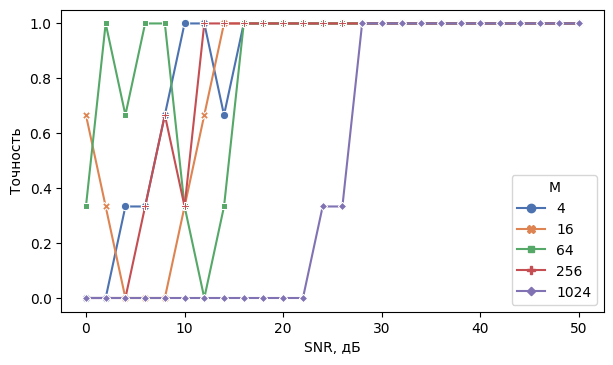

In [ ]:
df4 = test_df.drop(['Answers'], axis=1)\
.groupby(by=['M', 'SNR'], as_index=False).mean()
plt.figure(figsize=(7,4), dpi=100)
sns.lineplot(x='SNR', y='Result', data=df4, hue='M',
             style='M', markers=True, dashes=False,
             palette='deep')
plt.xlabel('SNR, дБ')
plt.ylabel('Точность')

Подсчет времени работы модели для 1 одного QAM сигнала

In [37]:
%%time
Analyzer.analyze(np.array([QAM_test[1]]))

CPU times: user 68.2 ms, sys: 993 µs, total: 69.2 ms
Wall time: 76.7 ms


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[4]